In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../Code\\process.py'>

In [3]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader.json")

Creating transform: random_video_loader
Adding folder '.\..\TrainingData\Processed\BallTracking\'
'.\..\TrainingData\Processed\BallTracking\balltracking_0.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_1.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_2.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_3.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_4.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_5.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_6.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_7.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_8.avi': 10000 frames found.
'.\..\TrainingData\Processed\BallTracking\balltracking_9.avi': 4073 frames found.
Loaded 94073 frames in random loader.
Distribution:
{'balltracking_.avi':

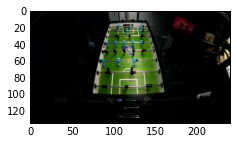

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


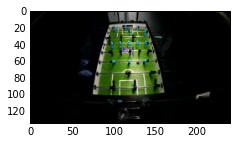

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


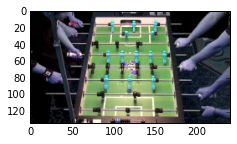

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


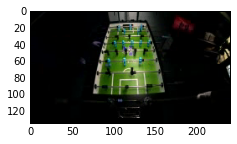

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


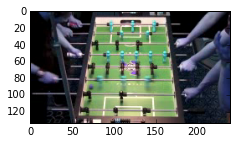

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


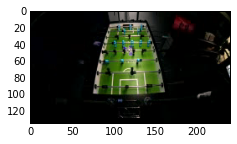

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


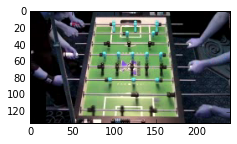

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


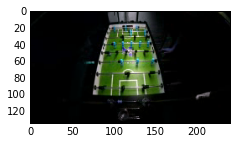

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


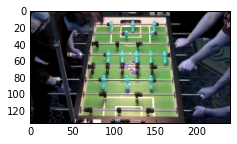

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


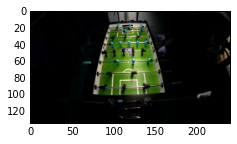

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(10):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [5]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
        


In [8]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000001),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

In [10]:
# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
batches_validation_per_epoch = 100
batches_training_per_epoch = 200
batch_size = 20
for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=1,
        workers=1,
        pickle_safe=False,
        initial_epoch=epoch)


Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1960 - categorical_accuracy: 0.1675    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1953 - categorical_accuracy: 0.1673    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1939 - categorical_accuracy: 0.1828    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1926 - categorical_accuracy: 0.1750    
Epoch 1/1
200/200 [==============================] - 78s - loss: 2.1901 - categorical_accuracy: 0.1875    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1870 - categorical_accuracy: 0.1865    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1834 - categorical_accuracy: 0.1818    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1775 - categorical_accuracy: 0.1913    
Epoch 1/1
200/200 [==============================] - 73s - loss: 2.1725 - categorical_accuracy: 0.1848    
Epoch 1/1
200/200 [==================

KeyboardInterrupt: 

In [6]:
# Test: Use a pre-trained InceptionV3 model as the base
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(134, 240, 3))  # this assumes K.image_data_format() == 'channels_last'

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 134, 240, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 66, 119, 32)   864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 66, 119, 32)   96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 66, 119, 32)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________